## ALGORÍTIMO GENÉTICO PARA OTIMIZAÇÃO DE ESCALAÇÃO DO FANTASY CARTOLA


O objetivo do algorítimo que vamos desenvolver abaixo é otimizar a escalação de times no Cartola FC levando em consideração o preço dos jogadores, a média dos mesmos e com a restrição do nosso *budget* disponível para escalação

In [21]:
#importando bibliotecas

import pandas as pd
import numpy as np

import random

import matplotlib.pyplot as plt



Usando a função read_html do pandas para pegar os dados do repositório caRtola, no GitHub. Vamos usar os dados da 37ª e 38ª rodada do campeonato brasileiro de 2020

In [22]:
#importando tabelas de dados

df_rdd_37 = pd.read_html("https://github.com/henriquepgomide/caRtola/blob/master/data/2020/rodada-37.csv")[0]
df_rdd_38 = pd.read_html("https://github.com/henriquepgomide/caRtola/blob/master/data/2020/rodada-38.csv")[0]



Vamos ao modo como os dados são apresentados.
Podemos reparar que no DataFrame referente à 38ª rodada aparecem informações não disponíveis no DataFrame referente à 37ª. No cartola, estas informações são chamadas de scouts. 

In [23]:
df_rdd_37.head()

,Unnamed: 0,Unnamed: 1,atletas.nome,atletas.slug,atletas.apelido,atletas.foto,atletas.atleta_id,atletas.rodada_id,atletas.clube_id,atletas.posicao_id,atletas.status_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,atletas.jogos_num,atletas.clube.id.full.name,athletes$atletas$scout
0,NaN,1,Marcos Felipe de Freitas Monteiro,marcos-felipe,Marcos Felipe,https://s.glbimg.com/es/sde/f/2020/08/11/1e384...,85004,37,266,gol,Provável,0,1.13,-0.91,2.21,16,266,NaN
1,NaN,2,Fábio Santos Romeu,NaN,Fábio Santos,https://s.glbimg.com/es/sde/f/2020/10/20/af376...,38229,37,264,lat,Provável,0,7.61,1.16,4.79,17,264,NaN
2,NaN,3,Diego Ribas da Cunha,NaN,Diego,https://s.glbimg.com/es/sde/f/2020/07/21/89f8a...,38909,37,262,mei,Provável,0,4.86,-0.28,1.88,24,Flamengo,NaN
3,NaN,4,Carlos Eduardo Santos Oliveira,eduardo,Eduardo,https://s.glbimg.com/es/sde/f/2020/03/02/a44ce...,50645,37,354,lat,Provável,0,3.86,1.15,1.58,13,354,NaN
4,NaN,5,Everton Augusto de Barros Ribeiro,NaN,Everton Ribeiro,https://s.glbimg.com/es/sde/f/2020/07/21/f06a0...,51772,37,262,mei,Provável,0,9.30,-0.65,4.67,31,Flamengo,NaN


In [24]:
df_rdd_38.head()

,Unnamed: 0,Unnamed: 1,atletas.nome,atletas.slug,atletas.apelido,atletas.foto,atletas.atleta_id,atletas.rodada_id,atletas.clube_id,atletas.posicao_id,atletas.status_id,atletas.pontos_num,atletas.preco_num,atletas.variacao_num,atletas.media_num,atletas.jogos_num,atletas.clube.id.full.name,CV,DD,FS,GS,PI,SG,CA,DS,FC,FD,FF,FT,G,I,A,GC,DP,PP
0,NaN,1,Diego Alves Carreira,diego-alves,Diego Alves,https://s.glbimg.com/es/sde/f/2020/07/21/b85ac...,38509,38,262,gol,Nulo,0.0,8.96,0.00,2.14,10,Flamengo,1.0,9.0,3.0,11.0,41.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,2,Leonardo Cittadini,leo-cittadini,Léo Cittadini,https://s.glbimg.com/es/sde/f/2019/03/30/47516...,70986,38,293,mei,Provável,13.3,13.77,1.59,4.04,29,293,NaN,NaN,47.0,NaN,102.0,NaN,6.0,69.0,54.0,13.0,21.0,1.0,5.0,3.0,NaN,NaN,NaN,NaN
2,NaN,3,Thiago Maia Alencar,thiago-maia,Thiago Maia,https://s.glbimg.com/es/sde/f/2020/07/21/e97cd...,89637,38,262,mei,Contundido,0.0,6.99,0.00,2.72,12,Flamengo,NaN,NaN,7.0,NaN,66.0,NaN,4.0,39.0,26.0,2.0,3.0,1.0,NaN,NaN,2.0,NaN,NaN,NaN
3,NaN,4,Felipe Aguilar Mendoza,aguilar,Aguilar,https://s.glbimg.com/es/sde/f/2020/07/11/d7b39...,95494,38,293,zag,Nulo,5.0,5.75,0.49,2.34,11,293,NaN,NaN,4.0,NaN,11.0,4.0,1.0,11.0,4.0,1.0,2.0,NaN,NaN,NaN,NaN,1.0,NaN,NaN
4,NaN,5,Aderbar Melo dos Santos Neto,santos,Santos,https://s.glbimg.com/es/sde/f/2019/03/30/e7ce0...,69012,38,293,gol,Provável,9.0,7.44,1.14,2.55,31,293,NaN,21.0,2.0,29.0,257.0,11.0,NaN,2.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN


Removendo as colunas que não iremos utilizar e renomeando as que restaram no datafreme a fim de facilitar a leitura e a compreensão do que elas representam

In [25]:
#limpando os dataframes

df_rdd_37.drop(columns=["Unnamed: 0", "Unnamed: 1", "atletas.slug", "atletas.foto", "atletas.rodada_id", "atletas.clube_id", "atletas.pontos_num", "atletas.variacao_num", "atletas.clube.id.full.name", "athletes$atletas$scout"], inplace = True)
df_rdd_38.drop(columns=["Unnamed: 0", "Unnamed: 1", "atletas.slug", "atletas.foto", "atletas.rodada_id", "atletas.clube_id", "atletas.pontos_num", "atletas.variacao_num", "atletas.clube.id.full.name", "CV", "DD", "FS", "GS", "PI", "SG", "CA", "DS", "FC", "FD", "FF", "FT", "G", "I", "A", "GC", "DP", "PP"], axis = 0, inplace = True)

#renomeando as colunas
data_frames = [df_rdd_37, df_rdd_38]
for data_frame in data_frames:
  data_frame.columns = ['Nome','Apelido', 'ID', 'Posição', 'Status', 'Preço', 'Media', 'Num Jogos']


Mostrando como os dados estão sendo apresentados depois das últimas mudanças

In [26]:
df_rdd_37.head()

,Nome,Apelido,ID,Posição,Status,Preço,Media,Num Jogos
0,Marcos Felipe de Freitas Monteiro,Marcos Felipe,85004,gol,Provável,1.13,2.21,16
1,Fábio Santos Romeu,Fábio Santos,38229,lat,Provável,7.61,4.79,17
2,Diego Ribas da Cunha,Diego,38909,mei,Provável,4.86,1.88,24
3,Carlos Eduardo Santos Oliveira,Eduardo,50645,lat,Provável,3.86,1.58,13
4,Everton Augusto de Barros Ribeiro,Everton Ribeiro,51772,mei,Provável,9.30,4.67,31


No cartola, os jogadores têm Status que indicam se eles jogarão, ou não, o jogo da rodada. Por motivos óbvios, só nos interessa os jogadores que têm status de provável.

Além disso, como usaremos a média como indicador de pontuação, vamos pegar os jogadores em que o número de jogos é maior, ou igual, à 10 para evitarmos jogadores com baixo número de jogos e média alta

In [27]:

df_rdd_38 = df_rdd_38[(df_rdd_38['Status'] == 'Provável') & (df_rdd_38['Num Jogos'] >= 10)]

Como podemos ver abaixo, nosso DataFrame só tem jogadores prováveis

In [28]:
df_rdd_38['Status'].value_counts()

Provável    195
Name: Status, dtype: int64

A média do jogador contida no dataframe da rodada 38 já está considerando o jogo, o que não faz sentido para a gente já que não temos essa informação antes da rodada acontecer. Por isto, vamos pegar a média contida no df_rdd_37 para cada jogador

In [29]:

data_frames = [df_rdd_37, df_rdd_38]
#definindo o nome como índice para facilitar o próximo passo
for data_frame in data_frames:
  data_frame.set_index("Nome", inplace=True)

#para cada jogador na rdd 38, pegar a média da rodada 37
for nome in df_rdd_38.index:
  df_rdd_38.loc[[nome], ['Media']] = float(df_rdd_37.loc[[nome]]['Media'])

df_rdd_38.reset_index(inplace=True) 

In [30]:
df_rdd_38

,Nome,Apelido,ID,Posição,Status,Preço,Media,Num Jogos
0,Leonardo Cittadini,Léo Cittadini,70986,mei,Provável,13.77,3.71,29
1,Aderbar Melo dos Santos Neto,Santos,69012,gol,Provável,7.44,2.34,31
2,Willian Marlon Ferreira Moraes,Willian Maranhão,87262,mei,Provável,2.61,1.14,22
3,Gilvan Souza Correa,Gilvan,82773,zag,Provável,5.82,1.86,21
4,Filipe Luís Kasmirski,Filipe Luís,38750,lat,Provável,7.66,4.26,29
...,...,...,...,...,...,...,...,...
190,Rodrigo Eduardo Costa Marinho,Rodriguinho,61033,mei,Provável,13.24,4.50,21
191,Lucas Fonseca da Silva,Lucas Fonseca,80189,zag,Provável,4.77,2.10,14
192,Danilo Carvalho Barcelos,Danilo Barcelos,84382,lat,Provável,3.50,0.74,18
193,Marco Aurélio de Oliveira Breves,Marcão,73476,tec,Provável,10.67,4.59,12


Vamos criar um DataFrame para cada posição e remover as colunas que não serão necessárias

In [31]:
#Criando um dataframe distindo para cada posição a fim de facilitar os próximos passos
df_gol = df_rdd_38[df_rdd_38['Posição'] == 'gol']
df_zag = df_rdd_38[df_rdd_38['Posição'] == 'zag']
df_lat = df_rdd_38[df_rdd_38['Posição'] == 'lat']
df_mei = df_rdd_38[df_rdd_38['Posição'] == 'mei']
df_ata = df_rdd_38[df_rdd_38['Posição'] == 'ata']
df_tec = df_rdd_38[df_rdd_38['Posição'] == 'tec']

df_posicoes = [df_gol, df_zag, df_lat, df_mei, df_ata, df_tec]
for posicao in df_posicoes:
  posicao.drop(columns=['Nome','Num Jogos', 'Posição', 'Status'], inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Transformando cada dataframe em listas de dicionários

In [32]:
#Criando uma lista de dicionários para cada posição
gol = df_gol.to_dict('records')
zag = df_zag.to_dict('records')
lat = df_lat.to_dict('records')
mei = df_mei.to_dict('records')
ata = df_ata.to_dict('records')
tec  = df_tec.to_dict('records')


Como podemos ver, o dataFrame contém lista de dicionários (um para cada jogador da posição) contendo as keys "Apelido", "ID", "Media" e "Preço"

In [33]:
gol

[{'Apelido': 'Santos', 'ID': 69012, 'Media': 2.34, 'Preço': 7.44},
 {'Apelido': 'Jean', 'ID': 90933, 'Media': 5.32, 'Preço': 9.5},
 {'Apelido': 'Felipe Alves', 'ID': 72372, 'Media': 2.06, 'Preço': 3.75},
 {'Apelido': 'Everson', 'ID': 72294, 'Media': 2.59, 'Preço': 9.35},
 {'Apelido': 'João Paulo', 'ID': 85425, 'Media': 3.1, 'Preço': 6.52},
 {'Apelido': 'Douglas Friedrich', 'ID': 78584, 'Media': 3.67, 'Preço': 10.21},
 {'Apelido': 'Tiago Volpi', 'ID': 72018, 'Media': 2.87, 'Preço': 10.95},
 {'Apelido': 'Marcos Felipe', 'ID': 85004, 'Media': 2.21, 'Preço': 3.12},
 {'Apelido': 'Fernando Miguel', 'ID': 71571, 'Media': 2.22, 'Preço': 6.95},
 {'Apelido': 'Tadeu', 'ID': 82453, 'Media': 2.95, 'Preço': 8.84},
 {'Apelido': 'Marcelo Lomba', 'ID': 68872, 'Media': 1.05, 'Preço': 8.78},
 {'Apelido': 'Hugo Souza', 'ID': 101574, 'Media': 2.69, 'Preço': 1.8},
 {'Apelido': 'Luan Polli', 'ID': 88916, 'Media': 1.35, 'Preço': 3.55},
 {'Apelido': 'Cleiton', 'ID': 93882, 'Media': 0.85, 'Preço': 1.98},
 {'Ape

Agora nós já temos os dados prontos. temos, para cada posição, uma lista de dicionários contento o ID (gene), Média (usado para fitness) e Preço (usado para restrição de valor total)

## ALGORÍTIMO GENÉTICO


Temos que definir parâmetros, oomo tamanho da pop., chance de mutação, chance de crossing-over, num. de indivíduos em cada pop. e número dos melhores indivíduos que será mantido para a próxima geração

In [37]:
MUT_ODDS = 0.01 #Chance de cada gene em um cromossomo ser mutado
CO_ODDS = 0.5 #Usando 50% para garantir que aproximadamente metade dos genes venham de cada um dos pais
NUM_INDIVIDUOS = 50 #número de indivíduos na população
NUM_MELHORES = 5 #número de melhores indivíduos da geração i que estarão na geração i+1
NUM_GERACOES = 500 #número de gerações do algorítimo genético (pode mudar dependendo da covergência)

BUDGET = 160 #No jogo, é conhecido como patrimônio. É o orçamento que temos para montar um time


random.seed(42)

**Funções do algorítimo genético**

Criando uma função para gerar um indivíduo.
Um indivíduo é uma possível solução para o problema a ser resolvido. 

No nosso caso, o indivíduo é um time, da forma que deve ser escalado no CartolaFc

In [38]:
def gera_individuo():
  
  """
  Função para gerar um índivíduo da população

  Argumento: -sem argumento
  Saída: Um time, contendo 1 goleiro, 2 zagueiros, 2 laterais, 3 meio-campistas, 3 atacantes e 1 técnico. O formato de saída será uma lista de dicionários
  """
  #sorteando os jogadores que irão compor o time
  pos_gol = list(np.random.choice(gol, size = 1))
  pos_zag = list(np.random.choice(zag, size = 2))
  pos_lat = list(np.random.choice(lat, size = 2))
  pos_mei = list(np.random.choice(mei, size = 3))
  pos_ata = list(np.random.choice(ata, size = 3))
  pos_tec = list(np.random.choice(tec, size = 1))
  #como o método np.random.choice retorna um numpy array e nós convertemos para lista, será necessário desempacotar
  
  time = [pos_gol[0], pos_zag[0], pos_zag[1], pos_lat[0], pos_lat[1], pos_mei[0], pos_mei[1], pos_mei[2], pos_ata[0], pos_ata[1], pos_ata[2], pos_tec[0]]
  return time




A partir da função de criar um indivíduo, vamos criar a nossa primeira população, que é um conjunto com n indivíduos

In [39]:
def gera_populacao(n):
  """
  Função para gerar a população inicial

  Argumento: numero de indivíduos na população
  Saída: uma lista com n indivíduos, sendo cada indivíduo uma lista de dicionários
  """

  populacao = []
  for i in range(n):
    populacao.append(gera_individuo())
  
  return populacao
  

Como nosso indivíduo é uma lista de dicionários, uma função para extrair conjuntamente informações de todos os jogadores que compõem o time é fundamental.



In [40]:
#Para facilitar alguns passos futuros, vamos criar uma função para extrair informações de cada indivíduo

def extrai_info(individuo, informacao:str):
  """
  Função para extrair uma informação específica de cada jogador (gene) de um indivíduo
  Ex.: Suponha que queremos o apelido de todos os jogadores de um time. Para isso, usaremos a função aqui definida.

  Argumentos: Um indivíduo (time) na forma de lista de dicionário, a informação desejada ["Apelido", "ID", "Media", "Preço"]
  Saída: Uma lista contendo a informação desejada de cada jogador do time passado
  """
  lista_info = []
  for i in range(len(individuo)):
    lista_info.append(individuo[i][informacao])
  return lista_info


Inserindo pressão do meio na população. Criando a função para calcular o desempenho de cada um dos indivíduos que compõem uma população

In [41]:
def calcula_fitness(populacao):
  """
  Função para calcular o fitness, isto é, o desempenho de cada indivíduo de uma população

  Argumentos: Uma população (lista de listas de dicionários)
  Saída: Uma lista contendo o fitness de cada indivíduo da população

  O desempenho será calculado dando valor 0 para indivíduos em que a soma dos preços for maior que o budget definido e, para os que tiverem preço inferior, o fitness será igual à soma das médias de cada jogador
  Como no cartola há a função de capitão, que dobra a pontuação do jogador que nós definirmos como capitão do time, nós iremos adicionar à soma das médias a mais alta média dentre todas de cada jogador
  """
  fitness_list = []

  for i in range(len(populacao)):
    #para cada indivíduo na população, vamos extrair a lista de médias e a lista de preços
    media = extrai_info(populacao[i], "Media")
    preco = extrai_info(populacao[i], "Preço")

    if sum(preco) > BUDGET:
      fitness_list.append(0)
    else:
      fitness_list.append(round(sum(media),2)+np.argmax(media)) #arredondando para duas casas decimais
  
  return fitness_list




Criando uma função que será responsável por fazer o crossover, isto é, cruzar dois indivíduos, combinando os seus genes.

In [42]:
def crossover(individuo1, individuo2):
  """
  Função para combinar dois indivíduos "pais" e, com isso, gerar um terceiro indivíduo "filho"

  Argumentos: dois indivíduos
  Saída: um terceiro indivíduo

  Nossa função vai gerar um indivíduo que vai ter os genes do individuo1 com probabilidade (1-CO_ODDS) e do indivíduo2 com probabilidade CO_ODDS
  """
  filho = individuo1.copy() #gerando o filho como cópia do indivíduo 1 e, a partir daí, vamos adicionar características do indivíduo 2 nele
  
  for i in range(len(filho)):
    list_ids = extrai_info(filho, "ID")

    if np.random.uniform() < CO_ODDS:

      if individuo2[i]["ID"] not in list_ids:
        filho[i] = individuo2[i]
  
  return filho



Criando uma função que será responsável por mutar o 'filho' gerado na função anterior.

Passo fundamental para inserirmos variabilidade genética em nossos indivíduos.

In [43]:
def mutacao(individuo):
  """
  Função para mutar um indivíduo qualquer:

  Argumento: Um indivíduo (lista de dicionários)
  Saída: Um indivíduo com algumas diferenças do indivíduo passado como argumento

  Nós vamos mutar o indivíduo trocando jogadores que compõem o time por novos jogadores aleatoriamente
  A probabilidade de cada jogador ser trocado é igual á MUT_ODDS
  """
  #criando um dicinário de índice para que possamos trocar os jogadores por outros da mesma posição
  indice = {0:gol, 1:zag, 2:zag, 3:lat, 4:lat, 5:mei, 6:mei, 7:mei, 8:ata, 9:ata, 10:ata, 11:tec}

  for i in range(len(individuo)):
    if np.random.uniform() < MUT_ODDS:
      ID_jogador = individuo[i]["ID"]
      while ID_jogador in extrai_info(individuo, "ID"):
        novo_jogador = np.random.choice(indice[i], size = 1)[0] #sorteando um novo jogador
        ID_jogador = novo_jogador["ID"] #Pegando o id do novo jogador para verificar se ele já faz parte do time
      individuo[i] = novo_jogador

  return individuo

Função para ordenar os indivíduos da população de acordo com o fitness de cada um. O indivíduo com maior fitness será o primeiro da lista e assim por diante.

*não é uma função obrigatória mas facilita na hora de implementar o elitismo no nosso AG*

In [44]:
def ordenar_lista(populacao, fitness):
  """
  Para facilitar os próximos passos, vamos criar uma função para ordenar os indivíduos de acordo com o fitness
  Ex.: Dada as listas ['abacate', 'mamão', 'laranja'] e [4, 7, 3], nossa função deverá retornar a lista ['mamão', 'abacate', 'laranja'] pois o elemento 'abacate' está relacionado com o número 4, o elemento 'mamão' com o número 7 e, por fim, o elemento 'laranja' está relacionado com o número 3
  Ex.: Dada as listas ['bola', 'casa', 'caixa'] e [1, 4, 9] retorna ['caixa', 'casa', 'bola']. O maior número, 9, corresponde à caixa e assim por diante

  Argumentos: população (lista de listas) e fitness (lista contendo o fitness para cada indivíduo da população)
  Saídas: a população com os indivíduos ordenados de acordo com o fitness e a lista de fitness também ordenada do maior para o menor valor

  """
  sorted_pop = []
  sorted_fit = fitness.copy()
  
  sorted_fit = sorted(sorted_fit, reverse=True) #Criando uma lista como cópia da lista de fitness e ordenando decrescentemente.
  
  #A ideia é percorrer a lista aux e, para cada valor encontrar indice do correspondente na lista de fitness e com isso conseguiremos localizar os valores na lista referente à população

  for value in sorted_fit:
    pos = fitness.index(value) #encontrando a posição do item na lista de fitness

    sorted_pop.append(populacao[pos]) #adicionando o valor na lista de valores sorteados
    
    fitness.pop(pos) #removendo o valor da lista de fitness para evitar problemas com dois valores iguais
    populacao.pop(pos) #removendo, também, o valor que foi adicionado
    
  return sorted_pop, sorted_fit
  
  

Função para sortear dois indivíduos na população para serem os 'pais'.

A seleção define chance maior para os indivíduos mais aptos (com maior fitness).

In [45]:
def escolhe_pais(populacao, fitness):
  """
  Uma função para poder escolher dois indivíduos que darão origem à um novo na função crossover()

  Argumentos: população (pode estar ordenada ou nao) e fitness referente à população
  Saída: Dois indivíduos escolhidos através do método da roleta proporcional*

  *o método da roleta será introduzido definindo o argumento fitness como weights na função random.choices()

  OBS: Usando random.choices() pois np.random.choice não consegue trabalhar com lista de listas de dicionários
  """
  parents = random.choices(populacao, weights=fitness, k = 2)
  
  
  return parents[0], parents[1]
  

Função para compor uma geração. Ela implementa o elitismo ao selecionar os N melhores indivíduos da população vigente e após isso a função pega os pais, cruza, muta o filho e adiciona na população até ela estar completa

In [46]:
def compoe_proxima_geracao(populacao, fitness):
  """
  Função para criar a proxima geraçao de indivíduos a partir da geração atual

  Argumentos: a população atual e o fitness relacionado. Neste passo é fundamental que os valores estejam ordenados pela função ordena_lista()
  Saída: Uma nova população de tamanho NUM_INDIVIDUOS, sendo a população uma lista de listas de dicionários

  PASSOS:
    -Pega os NUM_MELHORES indivíduos da população atual e adiciona na proxima população
    -Enquanto a população não estiver completa:
      -seleciona dois indivíduos 
      -faz o crossover dos dois indivíduos selecionados
      -muta o filho resultante do processo anterior
      -adiciona o filho à população
  """
  nova_populacao = populacao[:NUM_MELHORES] #adicionando os melhores da pop passada à nova pop

  while len(nova_populacao) < NUM_INDIVIDUOS:
    ind1, ind2 = escolhe_pais(populacao, fitness)
    filho = crossover(ind1, ind2)
    filho_mutado = mutacao(filho)
    
    nova_populacao.append(filho_mutado)
  
  return nova_populacao
    

Encaixando o quebra cabeça e montando o algorítimo genético

In [47]:
melhores_individuos = [] #lista que vai armazenar os melhores indivíduos em cada geração para que possamos visualizar graficamente

populacao = gera_populacao(NUM_INDIVIDUOS)

for geracao in range(NUM_GERACOES):
  fitness = calcula_fitness(populacao)
    
  populacao, fitness = ordenar_lista(populacao, fitness)
    
  #vamos adicionar o melhor fitness da geração para podermos ver a evolução posteriormente
  melhores_individuos.append(fitness[0])



  populacao = compoe_proxima_geracao(populacao, fitness)
    
  #Como definimos a população no último passo do for, é necessário calcular o desempenho desta população (a última) fora do laço
fitness = calcula_fitness(populacao)
populacao, fitness = ordenar_lista(populacao, fitness)
melhores_individuos.append(fitness[0])
  
melhor_time = extrai_info(populacao[0], "Apelido")
melhor_preco = sum(extrai_info(populacao[0], "Preço"))

## RESULTADOS

Como podemos ver, logo após a geração 100, o resultado melhora pela última vez e se mantém constante até o fim do algorítimo. 

Isso nos mostra que não precisamos de um número tão grande de gerações quanto o utilizado

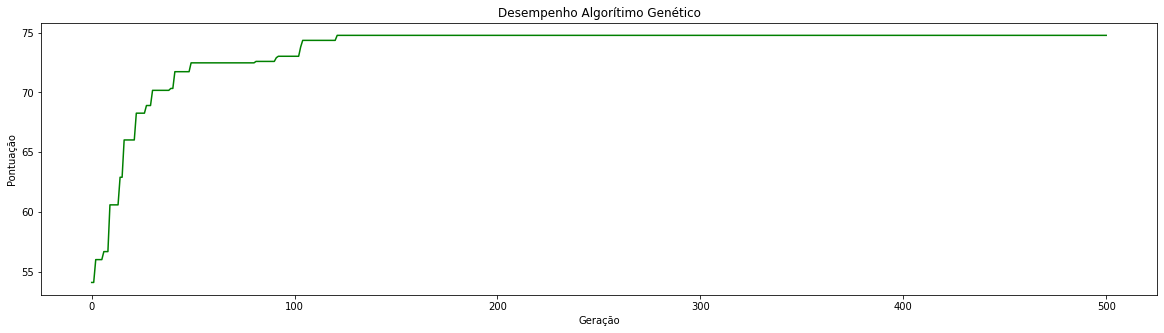

In [48]:
plt.figure(figsize=(20,5))
plt.style.context("classic")
plt.title("Desempenho Algorítimo Genético")
plt.plot(melhores_individuos, color = "green")
plt.xlabel("Geração")
plt.ylabel("Pontuação")
plt.show()

Melhor time

In [49]:
populacao[0]

[{'Apelido': 'Jean', 'ID': 90933, 'Media': 5.32, 'Preço': 9.5},
 {'Apelido': 'Fábio Sanches', 'ID': 71604, 'Media': 3.64, 'Preço': 6.09},
 {'Apelido': 'Matheus Ferraz', 'ID': 38632, 'Media': 3.63, 'Preço': 7.87},
 {'Apelido': 'Guilherme Arana', 'ID': 87228, 'Media': 5.21, 'Preço': 17.41},
 {'Apelido': 'Calegari', 'ID': 104276, 'Media': 5.65, 'Preço': 7.12},
 {'Apelido': 'Arrascaeta', 'ID': 87863, 'Media': 6.46, 'Preço': 17.87},
 {'Apelido': 'Raul', 'ID': 92496, 'Media': 5.2, 'Preço': 9.04},
 {'Apelido': 'Vina', 'ID': 71162, 'Media': 6.63, 'Preço': 11.34},
 {'Apelido': 'Keno', 'ID': 86485, 'Media': 6.38, 'Preço': 14.75},
 {'Apelido': 'Claudinho', 'ID': 92630, 'Media': 6.81, 'Preço': 16.6},
 {'Apelido': 'Gabriel', 'ID': 83257, 'Media': 6.26, 'Preço': 12.0},
 {'Apelido': 'Marcão', 'ID': 73476, 'Media': 4.59, 'Preço': 10.67}]

Preço do melhor time

In [50]:
sum(extrai_info(populacao[0], 'Preço'))

140.26

Nosso time ficou 20 unidades de preço abaixo do valor máximo permitido

## TESTES

Testando o desempenho do nosso AG com valores diferentes para a chance de mutação

In [51]:
##TESTES COM VALORES DE MUTAÇÃO DIFERENTES

resultados = []
mut = [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.8]
for valor_mutacao in mut:
  MUT_ODDS = valor_mutacao
  melhores_individuos = []

  populacao = gera_populacao(NUM_INDIVIDUOS)

  for geracao in range(NUM_GERACOES):
    fitness = calcula_fitness(populacao)
    
    populacao, fitness = ordenar_lista(populacao, fitness)
    
    #vamos adicionar o melhor fitness da geração para podermos ver a evolução posteriormente
    melhores_individuos.append(fitness[0])



    populacao = compoe_proxima_geracao(populacao, fitness)
    
  #Como definimos a população no último passo do for, é necessário calcular o desempenho desta população (a última) fora do laço
  fitness = calcula_fitness(populacao)
  populacao, fitness = ordenar_lista(populacao, fitness)
  melhores_individuos.append(fitness[0])

  resultados.append(melhores_individuos)
  

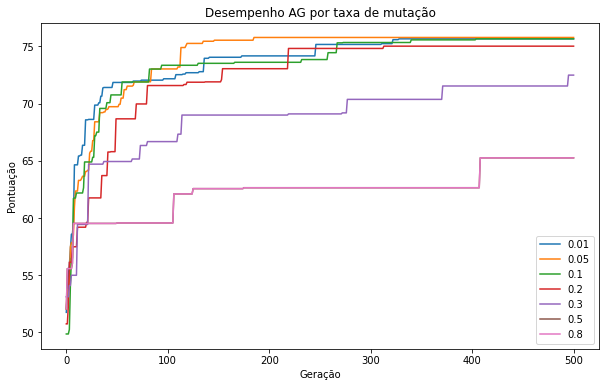

In [52]:
plt.figure(figsize = (10, 6))
plt.title("Desempenho AG por taxa de mutação")
plt.plot(resultados[0], label = str(mut[0]))
plt.plot(resultados[1], label = str(mut[1]))
plt.plot(resultados[2], label = str(mut[2]))
plt.plot(resultados[3], label = str(mut[3]))
plt.plot(resultados[4], label = str(mut[4]))
plt.plot(resultados[5], label = str(mut[5]))
plt.plot(resultados[5], label = str(mut[6]))
plt.legend()
plt.xlabel("Geração")
plt.ylabel("Pontuação")
plt.show()

Teste com números diferentes de indivíduos por população

In [53]:
##TESTES COM TAMANHOS DE POPULAÇÃO DIFERENTES
MUT_ODDS = 0.2
resultados = []
ind = [6, 10, 20, 30, 50, 100, 1000]
for numero_ind in ind:
  NUM_INDIVIDUOS = numero_ind
  melhores_individuos = []

  populacao = gera_populacao(NUM_INDIVIDUOS)

  for geracao in range(NUM_GERACOES):
    fitness = calcula_fitness(populacao)
    
    populacao, fitness = ordenar_lista(populacao, fitness)
    
    #vamos adicionar o melhor fitness da geração para podermos ver a evolução posteriormente
    melhores_individuos.append(fitness[0])



    populacao = compoe_proxima_geracao(populacao, fitness)
    
  #Como definimos a população no último passo do for, é necessário calcular o desempenho desta população (a última) fora do laço
  fitness = calcula_fitness(populacao)
  populacao, fitness = ordenar_lista(populacao, fitness)
  melhores_individuos.append(fitness[0])

  resultados.append(melhores_individuos)

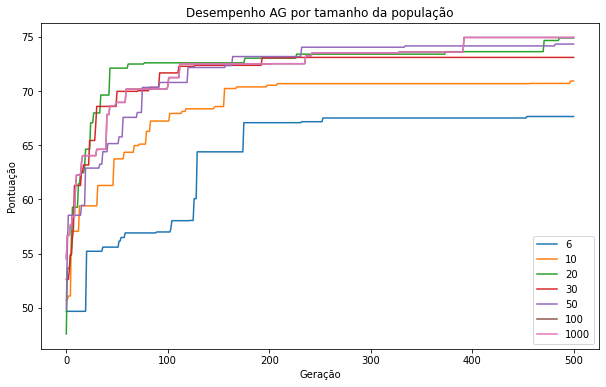

In [54]:
plt.figure(figsize = (10, 6))
plt.title("Desempenho AG por tamanho da população")
plt.plot(resultados[0], label = str(ind[0]))
plt.plot(resultados[1], label = str(ind[1]))
plt.plot(resultados[2], label = str(ind[2]))
plt.plot(resultados[3], label = str(ind[3]))
plt.plot(resultados[4], label = str(ind[4]))
plt.plot(resultados[5], label = str(ind[5]))
plt.plot(resultados[5], label = str(ind[6]))
plt.legend()
plt.xlabel("Geração")
plt.ylabel("Pontuação")
plt.show()